In [1]:
] activate .

  Activating project at `~/.julia/dev/HJB/examples`


In [2]:
] st

Status `~/.julia/dev/HJB/examples/Project.toml`
  [0c46a032] DifferentialEquations v7.11.0
  [f6369f11] ForwardDiff v0.10.36
  [a3cb4e6c] HJB v1.0.0-DEV `~/.julia/dev/HJB`
  [6fe1bfb0] OffsetArrays v1.12.10
  [7f7a1694] Optimization v3.19.3
  [36348300] OptimizationOptimJL v0.1.13
  [91a5bcdd] Plots v1.39.0
  [49802e3a] ProgressBars v1.5.1
  [5d786b92] TerminalLoggers v0.1.7


In [3]:
using ProgressBars

In [4]:
using HJB

In [5]:
Threads.nthreads()

16

In [6]:
using StaticArrays, LinearAlgebra, DifferentialEquations, Optimization, ForwardDiff, OptimizationOptimJL, Plots

In [1266]:
function smooth_min(a, b, k=20)
    # exponential smooth min
    res = exp( -k*a ) + exp( -k*b );
    return -log( res )/k;
end

function smooth_max(a, b, k=20)
    return (1/k) * log( exp(k*a) + exp(k*b))
end

smooth_max (generic function with 2 methods)

In [1267]:
smooth_max(0, 5.001)

5.001000000000001

In [1306]:
# define the dynamics
function f(t, x, u)
    return @SVector [x[2], u[1]]
end

# define the Hamiltonian
function H(t, x, V, DxV) # H(t, x, z, s)
    u1 = @SVector [1.0]
    u2 = @SVector [-1.0]
    H1 = DxV' * f(t, x, u1)
    H2 = DxV' * f(t, x, u2)
    γ = 0.5
    
    # return min(0, max(H1, H2) + γ*V)
    # return min(0, H2 + γ*V)
    # return min(0, max(H1, H2) + γ*V)
    return smooth_min(0, smooth_max(H1, H2) + γ * V )
end

# define the constraint function
function σ(x)
    xcon = sqrt(2)/2 - x[1]
    # xcon = 0.5 - x[1]^2
    return xcon
end

σ (generic function with 1 method)

In [1307]:
# t = 0.0
# x = [0.0, 1.0]
# V = 0.0
# s = randn(2)

# define all the derivatives
DxH(t, x, z, s) = ForwardDiff.gradient(xx -> H(t, xx, z, s), x)
DsH(t, x, z, s) = ForwardDiff.gradient(ss -> H(t, x, z, ss), s)

DxH!(r, t, x, z, s) = ForwardDiff.gradient!(r, xx -> H(t, xx, z, s), x)
DsH!(r, t, x, z, s) = ForwardDiff.gradient!(r, ss -> H(t, x, z, ss), s)

DzH(t, x, z, s) = ForwardDiff.derivative(zz -> H(t, x, zz, s), z)
Dσ(x) = ForwardDiff.gradient(σ, x)

Dσ (generic function with 1 method)

In [1308]:
DxH(0.0, [1.0, 1.0], 1.0, [1.0, 1.0])

2-element Vector{Float64}:
 0.0
 1.9287498479639176e-22

In [1309]:
DsH(0.0, [1.0, 1.0], 1.0, [1.0, 1.0])

2-element Vector{Float64}:
 1.9287498479639176e-22
 1.9287498479639176e-22

In [1310]:
DzH(0.0, [1.0, 1.0], 1.0, [1.0, 1.0])

9.643749239819588e-23

In [1311]:
Dσ([1.0, 1.0])

2-element Vector{Float64}:
 -1.0
 -0.0

In [1312]:
function characteristic_system!(D, state, params, t)
    N = 2 # dimension of the problem
    xinds = 1:N
    sinds = (N+1):(2N)
    zind = 2N + 1
    
    x = state[xinds] # state
    s = state[sinds] # costate
    z = state[zind] # characteristic

    D[xinds] = DsH(t, x, z, s) 
    D[sinds] = -DxH(t, x, z, s) - DzH(t, x, z, s)  * s
    D[zind] = dot(s, D[xinds]) - H(t, x, z, s)

    # DxH!(D[sinds], t, x, z, s)
    # DsH!(D[xinds], t, x, z, s)
    # D[sinds] .*= -1
    # D[sinds] -= DzH(t, x, z, s)*s

    return
end

characteristic_system! (generic function with 1 method)

In [1313]:
function solve_ode(y)

    xθ = y
    sθ = Dσ(y)
    zθ = σ(y)

    stateθ = vcat(xθ, sθ, zθ)

    tspan = (2.0, 0.0)

    prob = ODEProblem(characteristic_system!, stateθ, tspan)

    sol = solve(prob, save_everystep=false, save_end=true)

    return sol

end

solve_ode (generic function with 1 method)

In [1314]:
p = randn(2)
p = [sqrt(2)/2, 0.0]
@time sol = solve_ode(p)

  0.054742 seconds (18.75 k allocations: 1.131 MiB, 98.59% compilation time: 74% of which was recompilation)


retcode: Success
Interpolation: 1st order linear
t: 2-element Vector{Float64}:
 2.0
 0.0
u: 2-element Vector{Vector{Float64}}:
 [0.7071067811865476, 0.0, -1.0, -0.0, 0.0]
 [0.4332652708988625, 0.739542011033193, -1.4719879831508835, -1.1381795716872074, -0.07888649459735328]

In [1315]:
function cost_function(p, params)
    sol = solve_ode(p)
    xend = sol.u[end][1:2]
    xtarget = @SVector [0.0, 0.5]
    return norm(xend - xtarget)
end

cost_function (generic function with 1 method)

In [1316]:
cost_function(randn(2), nothing)

7.508961104684249

In [1317]:
# opt_f = OptimizationFunction(cost_function, Optimization.AutoForwardDiff())
# opt_prob = OptimizationProblem(opt_f, randn(2), nothing)
# @time opt_sol = solve(opt_prob, SimulatedAnnealing(),maxtime=5.0, maxiters=100)

In [1318]:
# cost_function(opt_sol.u,nothing)

In [1319]:
# opt_prob = OptimizationProblem(opt_f, opt_sol.u, nothing)
# @time opt_sol = solve(opt_prob, SimulatedAnnealing(),maxtime=5.0, maxiters=100)

In [1320]:
# cost_function(opt_sol.u,nothing)

In [1321]:
# opt_prob = OptimizationProblem(opt_f, opt_sol.u, nothing)
# @time opt_sol = solve(opt_prob, BFGS(),maxtime=5.0, maxiters=100)

In [1322]:
# cost_function(opt_sol.u,nothing)

In [1323]:
# opt_prob = OptimizationProblem(opt_f, opt_sol.u, nothing)
# @time opt_sol = solve(opt_prob, BFGS(),maxtime=5.0, maxiters=100)

In [1324]:
# cost_function(opt_sol.u,nothing)

In [1325]:
# @time sol = solve_ode(opt_sol.u)

In [1326]:
# @time sol = solve_ode([0.4, 0.1])

In [1327]:
#opt_prob = OptimizationProblem(opt_f, [0.7571726274469746, -0.205932512799178], nothing)# , lb = [-10.0, -10.0], ub=[10.0, 10.0])

In [1328]:
#@time opt_sol = solve(opt_prob, BFGS(),maxtime=5.0, maxiters=100)

In [1329]:
#opt_sol

In [1330]:
#cost_function(opt_sol.u,nothing)

In [1331]:
#cost_function([sqrt(2)/2, 0.], nothing)

In [1332]:
#sol = solve_ode([0.6, 0.])

In [1333]:
#plot(sol)

In [1334]:
function plot_grid!(data, grid::HJB.Grid{2, F}) where {F}
    # for now only supports plotting 2 dimensional problems

    x1s = HJB.getDomainAxes(grid, 1)
    x2s = HJB.getDomainAxes(grid, 2)

    heatmap!(x1s, x2s, data[HJB.DomainIndices(grid)]')

end

plot_grid! (generic function with 1 method)

In [1335]:
function nanmin(a, b)
    if !isnan(a) && !isnan(b)
        return min(a, b)
    elseif isnan(a) && !isnan(b)
        return b
    elseif !isnan(a) && isnan(b)
        return a
    else
        return NaN
    end
end

function nanmax(a, b)
    if !isnan(a) && !isnan(b)
        return max(a, b)
    elseif isnan(a) && !isnan(b)
        return b
    elseif !isnan(a) && isnan(b)
        return a
    else
        return NaN
    end
end
        

nanmax (generic function with 1 method)

In [1336]:
x1s = -5:0.025:5
x2s = -5:0.025:5
grid = HJB.Grid((x1s, x2s))
value_function = HJB.allocate_grid(grid, x-> NaN);

In [1346]:
# count = 0
Threads.@threads for i in ProgressBar(1:1000)
    # L = 2.5
    # y = 2L*rand(2) .- L
    y = randn(2)
    sol = solve_ode(y)
    x0 = sol.u[end][1:2]
    z0 = sol.u[end][end]
    ind = HJB.state2ind(grid, x0)
    if ind in HJB.DomainIndices(grid)
        # value_function[ind] = nanmax(value_function[ind], z0)
        value_function[ind] = z0
        # count += 1
        # @show i, x0, z0
    end
end
# @show count

0.1%┣                                         ┫ 1/1.0k [00:00<Inf:Inf, InfGs/it]
100.0%┣██████████████████████████████████████┫ 1.0k/1.0k [00:00<00:00, 8.3kit/s]


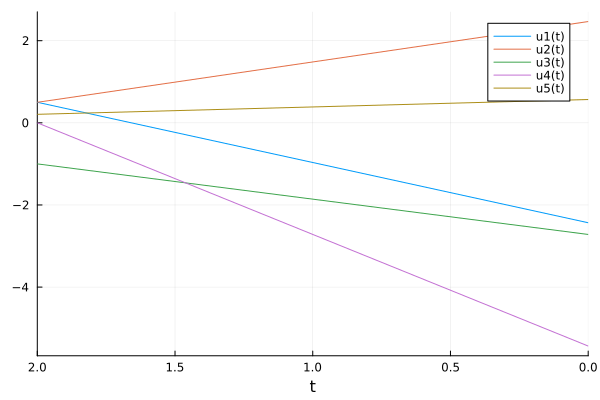

In [1347]:
plot(sol)

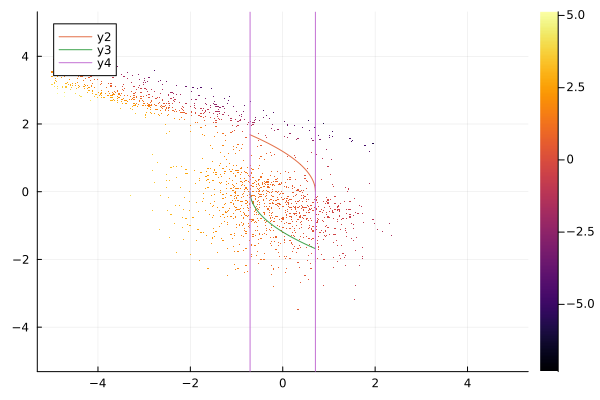

In [1348]:
plot()
plot_grid!(value_function, grid)
# plot!(p-> sqrt(2 * 1 * (sqrt(2)/2 - p)), -1, sqrt(2)/2)
# vline!([sqrt(2)/2])
plot!(p-> sqrt(2 * 1 * (sqrt(2)/2 - p)), -sqrt(2)/2, sqrt(2)/2)
plot!(p-> -sqrt(2 * 1 * (p + sqrt(2)/2)), -sqrt(2)/2, sqrt(2)/2)
vline!([-sqrt(2)/2, sqrt(2)/2])

In [1349]:
solve_ode([-0.1, 0.01])

retcode: Success
Interpolation: 1st order linear
t: 2-element Vector{Float64}:
 2.0
 0.0
u: 2-element Vector{Vector{Float64}}:
 [-0.1, 0.01, -1.0, -0.0, 0.8071067811865476]
 [-0.10000381608753453, 0.010001456282124913, -1.0001908133178128, -0.00038166304303251854, 0.8070915159357356]

In [1350]:
categorize(v; eps=0) = isnan(v) ? 0 : (v >= eps ? 1 : -1 )

categorize (generic function with 1 method)

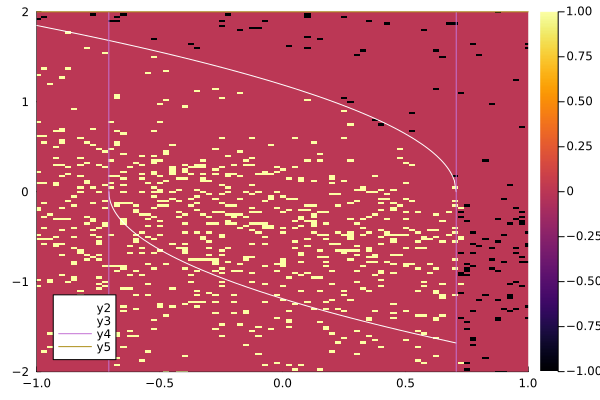

In [1351]:
plot()
plot_grid!(categorize.(value_function; eps=0), grid)
plot!(xlims=(-1,1), ylims  = (-2,2))
plot!(p-> sqrt(2 * 1 * (sqrt(2)/2 - p)), -5, sqrt(2)/2,  linecolor=:white)
plot!(p-> -sqrt(2 * 1 * (p + sqrt(2)/2)), -sqrt(2)/2, sqrt(2)/2, linecolor=:white)

# vline!([-sqrt(2)/2, sqrt(2)/2])
# plot!(p-> sqrt(2 * 1 * (sqrt(2)/2 - p)), -sqrt(2)/2, sqrt(2)/2, linecolor=:white)
# plot!(p-> -sqrt(2 * 1 * (p + sqrt(2)/2)), -sqrt(2)/2, sqrt(2)/2)
vline!([-sqrt(2)/2, sqrt(2)/2])
hline!([2.])


In [1352]:
sol = solve_ode([0.5, 0.5])

retcode: Success
Interpolation: 1st order linear
t: 2-element Vector{Float64}:
 2.0
 0.0
u: 2-element Vector{Vector{Float64}}:
 [0.5, 0.5, -1.0, -0.0, 0.20710678118654757]
 [-2.4331395472622144, 2.466135320125533, -2.7180412423144227, -5.4356008520021515, 0.5680019735669817]

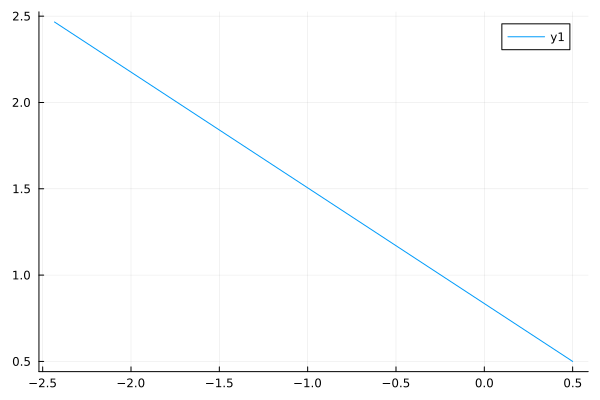

In [1344]:
plot([u[1] for u in sol.u], [u[2] for u in sol.u])

In [1345]:
function get_value_function(x0)
    function cost_function(p, params)
        sol = solve_ode(p)
        xend = sol.u[end][1:2]
        return norm(xend - params)
    end
    opt_f = OptimizationFunction(cost_function, Optimization.AutoForwardDiff())
    opt_prob = OptimizationProblem(opt_f, randn(2), x0)
    opt_sol = solve(opt_prob, SimulatedAnnealing(),maxtime=5.0, maxiters=100)

    opt_prob2 = OptimizationProblem(opt_f, opt_sol.u, x0)
    opt_sol2 = solve(opt_prob2, BFGS(),maxtime=5.0, maxiters=100)

    # check the solution
    @show cost_function(opt_sol2.u, x0)
    
    sol = solve_ode(opt_sol2.u)
    
    return sol.u[end][end]
end

get_value_function (generic function with 1 method)

In [837]:
get_value_function([0,0.])

cost_function(opt_sol2.u, x0) = 1.0423310564808068e-6


0.7071073525874567

In [838]:
get_value_function([0,1.])

cost_function(opt_sol2.u, x0) = 0.6787191141166571


1.2836100208100025

In [781]:
nanmax(-1.0, NaN)

-1.0

In [782]:
isnan(NaN)

true

In [772]:
constraint = HJB.allocate_grid(grid, x-> σ(x))

87×167 OffsetArray(::Matrix{Float64}, -3:83, -3:163) with eltype Float64 with indices -3:83×-3:163:
 0.0  0.0  0.0   0.0         0.0        …   0.0        0.0  0.0  0.0
 0.0  0.0  0.0   0.0         0.0            0.0        0.0  0.0  0.0
 0.0  0.0  0.0   0.0         0.0            0.0        0.0  0.0  0.0
 0.0  0.0  0.0   1.70711     1.70711        1.70711    0.0  0.0  0.0
 0.0  0.0  0.0   1.68211     1.68211        1.68211    0.0  0.0  0.0
 0.0  0.0  0.0   1.65711     1.65711    …   1.65711    0.0  0.0  0.0
 0.0  0.0  0.0   1.63211     1.63211        1.63211    0.0  0.0  0.0
 0.0  0.0  0.0   1.60711     1.60711        1.60711    0.0  0.0  0.0
 0.0  0.0  0.0   1.58211     1.58211        1.58211    0.0  0.0  0.0
 0.0  0.0  0.0   1.55711     1.55711        1.55711    0.0  0.0  0.0
 0.0  0.0  0.0   1.53211     1.53211    …   1.53211    0.0  0.0  0.0
 0.0  0.0  0.0   1.50711     1.50711        1.50711    0.0  0.0  0.0
 0.0  0.0  0.0   1.48211     1.48211        1.48211    0.0  0.0  0.0
 ⋮ 

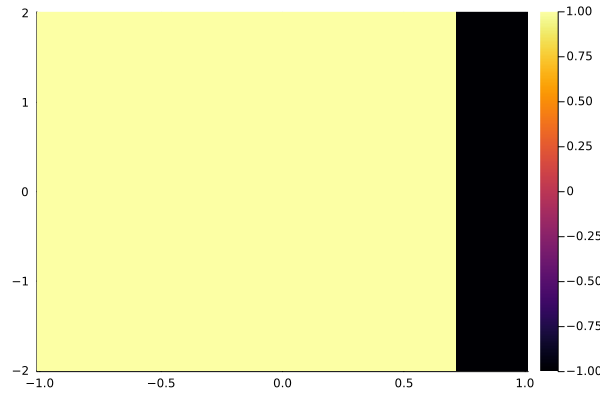

In [773]:
plot()
plot_grid!(categorize.(constraint), grid)